Feature Regressions using Machine Learning (ML) & Deep Learning (DL) Algorithms

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys, os, time, math
import h5py 
sys.path.append('/home/groups/ZuckermanLab/jalim/instalLocal/celltraj/celltraj')
import jcTrajectory_CP as cellTraj
import pickle, subprocess
import umap, scipy, json 
from csaps import csaps
import string, ast 
from joblib import dump, load
from datetime import date
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

2024-06-12 16:23:54.610547: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-12 16:23:55.918975: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-12 16:24:21.201309: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
from sklearn.datasets import make_classification, make_regression
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, LassoCV
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

In [5]:
trajl = 2 
wellsInfo = 'Awells'
conditions = ['A2'] # LIGANDS or CONDITIONS
tmSet = ['EGF1']
n_conditions = len(tmSet) # Total number of Ligand Conditions
today = date.today()
date2day = today.strftime("%b%d-%Y")
sysName = 'LI204601_P'
figid = f"{sysName}_{date2day}"

In [6]:
# Indices for the ligands 
inds_tmSet = [i for i in range(n_conditions)]
inds_tmSet = np.array(inds_tmSet).astype(int)
nfovs = 4
fovs = [i for i in range(1, nfovs + 1)]
fovs = np.array(fovs).astype(int)
dateSet = ['']
pathSet = ['/home/groups/ZuckermanLab/jalim/LI204601_INCUCYTE/segsCellPose/bayesianTrackTest/']
imagingSet = [0 for i in range(n_conditions)]
modelList = [None]*(nfovs*(n_conditions))
modelList_conditions = np.zeros(nfovs*(n_conditions)).astype(int)

In [7]:
i = 0
icond = 0
for cond in conditions:
    for fov in fovs:
       modelList_conditions[i] = icond
       modelList[i] = pathSet[imagingSet[icond]]+sysName+'_'+cond+'_'+str(fov)+dateSet[imagingSet[icond]]
       #print("Models: ",modelList[i])
       i += 1
    icond += 1

nmodels = len(modelList)
modelSet = [None]*nmodels
indgood_models = np.array([]).astype(int)

In [8]:
for i in range(nmodels):
    try:
        objFile = modelList[i]+'.obj'
        objFileHandler = open(objFile,'rb')
        modelSet[i] = pickle.load(objFileHandler)
        print(f"loaded {objFile} with {modelSet[i].cells_indSet.size} cells")
        objFileHandler.close()
        test = len(modelSet[i].linSet)
        indgood_models = np.append(indgood_models,i)
    except:
        print("ERROR in reading *.obj files")
        sys.exit(0)

loaded /home/groups/ZuckermanLab/jalim/LI204601_INCUCYTE/segsCellPose/bayesianTrackTest/LI204601_P_A2_1.obj with 51054 cells
loaded /home/groups/ZuckermanLab/jalim/LI204601_INCUCYTE/segsCellPose/bayesianTrackTest/LI204601_P_A2_2.obj with 97764 cells
loaded /home/groups/ZuckermanLab/jalim/LI204601_INCUCYTE/segsCellPose/bayesianTrackTest/LI204601_P_A2_3.obj with 58579 cells
loaded /home/groups/ZuckermanLab/jalim/LI204601_INCUCYTE/segsCellPose/bayesianTrackTest/LI204601_P_A2_4.obj with 58341 cells


In [9]:
n_frames = 193 # Total number of frames (image snapshots) in one condition per FOVs
cellnumber_stdSet = np.ones(nmodels)*np.inf
# range of frame indices where cell numbers are higher: ~70-98%
sframe = 70.*n_frames/100.; sframe = math.ceil(sframe)
eframe = 98.5*n_frames/100.; eframe = math.ceil(eframe)
cellnumber_frames = np.arange(sframe, eframe).astype(int)
cellnumber_std_cut = .50 # This was set to 0.10 by Jeremy 
frames = np.arange(n_frames)
# Abscissas at which smoothing will be done using CSAPS package
abSmooth = np.linspace(frames[0], frames[-1], 10000)

In [10]:
for i in indgood_models:
    ncells = np.zeros(n_frames)
    ncells_smooth = np.zeros_like(ncells)
    for iS in range(n_frames):
        ncells[iS] = np.sum(modelSet[i].cells_frameSet == iS)
    # Cubic Spline Approximation (CSAPS) to smoothen the data
    splfov = csaps(frames, ncells/ncells[0], abSmooth, smooth = 0.98) # Scaled by ncells[0] to avoid large numbers
    ncells_smooth = splfov*ncells[0] # smoothened cell numbers reverse scaled back to original
    cellnumber_std = np.std(ncells[cellnumber_frames] - ncells_smooth[cellnumber_frames])/np.mean(ncells[cellnumber_frames])
    cellnumber_stdSet[i] = cellnumber_std # Standard Deviation in Cell Numbers		

In [11]:
indhigh_std = np.where(cellnumber_stdSet > cellnumber_std_cut)[0]
indgood_models = np.setdiff1d(indgood_models, indhigh_std)

inds_tmSet_models = np.zeros(nmodels).astype(int)
inds_imagingSet_models = np.zeros(nmodels).astype(int)
i = 0
icond = 0
for cond in conditions:
    for fov in range(nfovs):
        inds_tmSet_models[i] = inds_tmSet[icond] # Assign indices "tmSet" to all FOVs
        inds_imagingSet_models[i] = imagingSet[icond]
        i += 1
    icond = icond + 1

In [12]:
for i in indgood_models:
    if inds_imagingSet_models[i] == 0:
        modelSet[i].Xf[np.isnan(modelSet[i].Xf)] = 0.0 #just replace with zeros for now? Not sure best...

In [13]:
n_COMfeatures = 3
Xf_com0 = np.zeros((0, n_COMfeatures))
for i in indgood_models:
    if inds_imagingSet_models[i] == 0:
        Xf_com0 = np.append(Xf_com0,modelSet[i].Xf_com, axis = 0)

av_dx = np.nanmean(Xf_com0[:, 0])
std_dx = np.nanstd(Xf_com0[:, 0])
for i in indgood_models:
    modelSet[i].Xf_com[:, 0] = (modelSet[i].Xf_com[:, 0] - av_dx)/std_dx

In [14]:
wctm = cellTraj.Trajectory() # import Trajectory object 
# Cell features: Zernike (49), Haralick (13), Shape (15), Boundary (15) --> total 92
n_features = modelSet[indgood_models[0]].Xf.shape[1]
Xf = np.zeros((0, n_features))
indtreatment = np.array([])
indcellSet = np.array([])
for i in indgood_models:
    if inds_imagingSet_models[i] == 0:
        Xf = np.append(Xf, modelSet[i].Xf, axis = 0)
        # Indices for each model for later access using them
        indtreatment = np.append(indtreatment, i*np.ones(modelSet[i].Xf.shape[0])) 
        indcellSet = np.append(indcellSet, modelSet[i].cells_indSet)

indtreatment = indtreatment.astype(int)
indcellSet = indcellSet.astype(int)

In [15]:
for i in indgood_models:
    if inds_imagingSet_models[i] == 0:
        indsf = np.where(indtreatment == i)[0]
        modelSet[i].Xf = Xf[indsf, :]

indgood_models = indgood_models[np.where(inds_imagingSet_models[indgood_models] == 0)[0]]

In [16]:
self = wctm
all_trajSet = [None]*nmodels
for i in indgood_models:
    print(f"Get single-cell trajectories of model: {i}")
    modelSet[i].get_unique_trajectories()
    all_trajSet[i] = modelSet[i].trajectories.copy()

Get single-cell trajectories of model: 0
tracked cell 50891, 25 tracks, 46600 left
tracked cell 50763, 23 tracks, 42400 left
tracked cell 50735, 51 tracks, 41500 left
tracked cell 50076, 1 tracks, 37700 left
tracked cell 49741, 1 tracks, 37600 left
tracked cell 49307, 1 tracks, 37500 left
tracked cell 49056, 18 tracks, 37400 left
tracked cell 48763, 1 tracks, 37100 left
tracked cell 48214, 1 tracks, 36900 left
tracked cell 48008, 1 tracks, 36800 left
tracked cell 47562, 1 tracks, 36500 left
tracked cell 46286, 1 tracks, 35900 left
tracked cell 46119, 3 tracks, 35700 left
tracked cell 45624, 1 tracks, 35600 left
tracked cell 42924, 7 tracks, 34200 left
tracked cell 41889, 2 tracks, 33800 left
tracked cell 41728, 1 tracks, 33700 left
tracked cell 40948, 1 tracks, 33300 left
tracked cell 39770, 1 tracks, 32900 left
tracked cell 39018, 1 tracks, 32500 left
tracked cell 38257, 1 tracks, 32300 left
tracked cell 38063, 6 tracks, 32200 left
tracked cell 37504, 1 tracks, 32000 left
tracked cell

In [17]:
# Get snippets along with their full single-cell trajectory indices  
def get_snippets_with_traj_inds(self, seg_length): 
    n_sctraj = len(self.trajectories) # Number of Single-Cell Trajectories 
    traj_segSet = np.zeros((0, seg_length)).astype(int)
    ind_map_snippet_fulltraj = np.array([])
    for ind_traj in range(n_sctraj):
        cell_traj = self.trajectories[ind_traj] # Select a single-cell trajectory 
        traj_len = cell_traj.size
        #print("Length of a Single-Cell Trajectory:",traj_len)
        if traj_len >= seg_length:
            for ic in range(traj_len - seg_length):
                traj_seg = cell_traj[ic:ic+seg_length]
                traj_segSet = np.append(traj_segSet, traj_seg[np.newaxis, :], axis = 0)
                # Save indices of all snippets corresponding to "FULL" single-cell trajectory 
                ind_map_snippet_fulltraj = np.append(ind_map_snippet_fulltraj, ind_traj)
                #print("Indices to map snippets to the full trajectory:",ind_map_snippet_fulltraj)
    return ind_map_snippet_fulltraj, traj_segSet

Single-cell Trajectories Over The Cell Features

In [18]:
Xf_traj = np.zeros((0, n_features*trajl + n_COMfeatures*trajl))
indtreatment_traj = np.array([])
indstack_traj = np.array([])
indframes_traj = np.array([])
indmodel_traj_snippets = np.array([])
for i in indgood_models:
    print(f'Building trajectory data for model: {i}')
    modelSet[i].trajectories = all_trajSet[i].copy() # ALL Single-Cell trajectories 
    modelSet[i].trajl = trajl # Trajectory snippet length 
    # Get trajectory snippets of (all trajectories) a given length in a sliding window and mapped with single-cell trajectory indices 
    modelSet[i].snippet_map_fulltraj_inds, modelSet[i].traj = get_snippets_with_traj_inds(modelSet[i], trajl)
    # Xpca (feature info) along the single-cell trajectory snippets, extracted directly from cell indices unique within a 'model' 
    data = modelSet[i].Xf[modelSet[i].traj, :] 
    datacom = modelSet[i].Xf_com[modelSet[i].traj, :]
    data = data.reshape(modelSet[i].traj.shape[0], modelSet[i].Xf.shape[1]*trajl)
    datacom = datacom.reshape(modelSet[i].traj.shape[0], modelSet[i].Xf_com.shape[1]*trajl)
    data = np.append(data, datacom, axis = 1)
    indgood = np.where(np.sum(np.isnan(data), axis = 1) == 0)[0] # Consider models as "Good" that don't have NaN in "data" 
    data = data[indgood, :]
    modelSet[i].traj = modelSet[i].traj[indgood, :] # Cleaned trajectory snippets if any NaN 
    modelSet[i].snippet_map_fulltraj_inds = modelSet[i].snippet_map_fulltraj_inds[indgood]
    # Store all trajectory snippets of a given length (picked in a sliding window) 
    Xf_traj = np.append(Xf_traj, data, axis = 0) 
    indtreatment_traj = np.append(indtreatment_traj, i*np.ones(data.shape[0])) # Indices of Treatments (Models) Along Trajectory Snippets 
    indstacks = modelSet[i].cells_imgfileSet[modelSet[i].traj[:, 0]]
    indstack_traj = np.append(indstack_traj, indstacks)
    ind_frames = modelSet[i].cells_frameSet[modelSet[i].traj[:, 0]].astype(int) # Frame indices at the start of snippets
    ind_frames = ind_frames + trajl # Frame indices at the end of snippets
    indframes_traj = np.append(indframes_traj, ind_frames) # Starting Frame Indices of ALL snippets
    indtraj_snippets = modelSet[i].snippet_map_fulltraj_inds
    indmodel_traj_snippets = np.append(indmodel_traj_snippets, indtraj_snippets) # Save for all models: map of snippets to the sc trajectories

Building trajectory data for model: 0
Building trajectory data for model: 1
Building trajectory data for model: 2
Building trajectory data for model: 3


In [19]:
inds_conditions = [None]*n_conditions
for imf in range(n_conditions):
    indmodels = np.intersect1d(indgood_models, np.where(inds_tmSet_models == imf)[0])
    indstm = np.array([])
    for im in indmodels:
        indtm = np.where(indtreatment_traj == im)
        indstm = np.append(indstm, indtm)
    inds_conditions[imf] = indstm.astype(int).copy() # Condition (Model) specific trajectory snippet indices: Add up all FOVs
    #print(inds_conditions[imf])

In [20]:
# Get Cross correlations & respective frame numbers along all single-cell trajectories
def get_cross_corr_all_single_cell_trajs(filename):
      cross_corr_sctraj = []
      frame_num_sctraj = []
      with open(filename, 'r') as file_in:
          # Create an iterator over the file lines 
          file_iter = iter(file_in)
          try:
              while True:
                  # Read two lines at a time: Cross correlations & the corresponding frame numbers
                  line1 = next(file_iter).strip()
                  if line1:
                          data = ast.literal_eval(line1)
                          cross_corr_sctraj.append(data)
                          line2 = next(file_iter).strip()
                          # Parse line2 as a list of integers
                          frame_numbers = ast.literal_eval(line2)   
                          frame_num_sctraj.append(frame_numbers)
          except StopIteration:
              # End of file reached
              pass
      cross_corr_all_sctraj_file = cross_corr_sctraj
      frame_num_all_sctraj_file = frame_num_sctraj
      
      return cross_corr_all_sctraj_file, frame_num_all_sctraj_file

In [21]:
cc_path = '/home/groups/ZuckermanLab/jalim/LI204601_INCUCYTE/dcompCCtraj_states/'

In [22]:
X = [None] * nfovs
y = [None] * nfovs

for fov in fovs:
    # Get cross-correlation values along all single-cell trajectories  
    cc_filename = f"{cc_path}{sysName}_{conditions[0]}_{fov}.dat"
    cross_correlations, frame_numbers = get_cross_corr_all_single_cell_trajs(cc_filename)

    cc_values_last_frames = []
    model_indc = fov - 1
    indstm = np.where(indtreatment_traj == model_indc)[0]
    fid_snippets = indframes_traj[indstm].astype(int) # Map frame indices of snippets
    indc_map_fulltraj_snippets = indmodel_traj_snippets[indstm].astype(int) # Map Indices of Full Trajectory to Snippets 
    ################## Identify the "FULL" trajectory index and locate snippets within it ##################
    for j, ind_fulltraj in enumerate(indc_map_fulltraj_snippets):
        possible_indices = np.where(frame_numbers[ind_fulltraj] == fid_snippets[j])  
        indc_ccvals_traj = possible_indices[0][0]
        #print(f'Indices of Entire Traj: {ind_fulltraj}, Indices of CC_traj: {indc_ccvals_traj}')
        cc_vals = cross_correlations[ind_fulltraj][indc_ccvals_traj]
        #print(f'CC values: {cc_vals}, Indices of Entire Traj: {ind_fulltraj}, Indices of CC trajectory: {indc_ccvals_traj}')
        cc_values_last_frames.append(cc_vals)
    cc_values_last_frames = np.array(cc_values_last_frames)
    X_traj_model = Xf_traj[indstm]
    X[fov-1] = X_traj_model
    y[fov-1] = cc_values_last_frames

Leaving One (FOV) Out Cross Validations

In [23]:
num_features = 10
pca = PCA(n_components = num_features)
n_bins = 100

In [24]:
model_linRegFOV = LinearRegression(n_jobs=-1)

<Figure size 640x480 with 0 Axes>

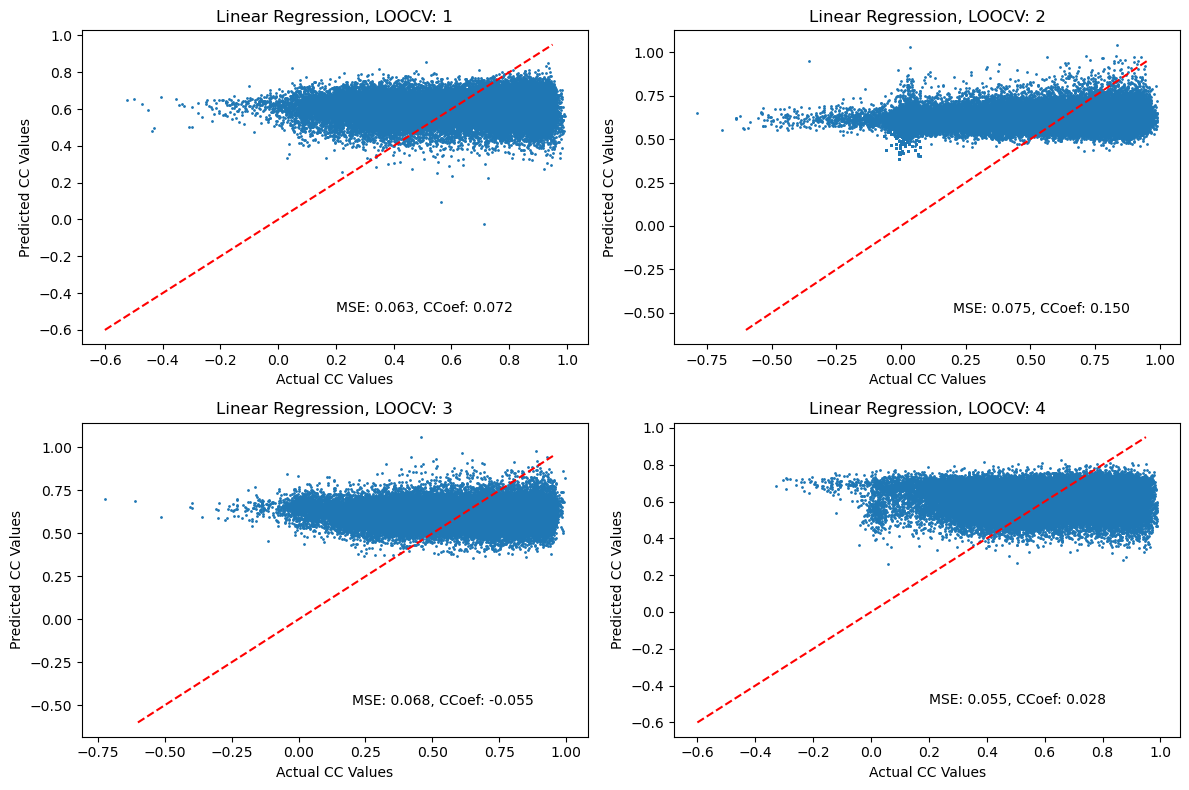

In [25]:
plt.clf()
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 8))
axs = axs.flatten()
for fov in fovs:
    test_fov = fov - 1
    train_fovs = np.delete(fovs, test_fov)
    train_fovs = train_fovs - 1
    X_test = X[test_fov]
    y_test = y[test_fov]
    X_train = np.zeros((0, X[0].shape[1]))
    y_train = np.zeros(0)
    for it_fov in train_fovs:
        X_train = np.append(X_train, X[it_fov], axis = 0)
        y_train = np.append(y_train, y[it_fov], axis = 0)
    pca.fit(X_train) 
    Xpca_train = pca.transform(X_train)
    pca.fit(X_test) 
    Xpca_test = pca.transform(X_test)
    model_linRegFOV.fit(Xpca_train, y_train)
    """
    plt.figure(figsize = (9, 6))
    plt.hist(y_train, bins = n_bins, alpha = 0.5, color = 'g', label = 'Trainng Set')
    plt.hist(y_test, bins = n_bins, alpha = 0.5, color='r', label = 'Test Set')
    plt.xlabel('CC Values')
    plt.ylabel('Frequency')
    plt.title('Histogram of CC Values')
    plt.legend()
    plt.grid(True)
    plt.show()
    """
    # Predict on the test set: Linear Regression
    y_pred_linRegLOFO = model_linRegFOV.predict(Xpca_test)
    mse_test = mean_squared_error(y_test, y_pred_linRegLOFO)
    # Predict on the training set: Linear Regression
    #y_pred_linRegLOFO_train = model_linRegFOV.predict(Xpca_train)
    #mse_train = mean_squared_error(y_train, y_pred_linRegLOFO_train)
    correlation_matrix = np.corrcoef(y_test, y_pred_linRegLOFO)
    #correlation_matrix = np.corrcoef(y_train, y_pred_linRegLOFO_train)
    corr_coeff = correlation_matrix[0, 1]
    #axs[fov-1].scatter(y_test_trim, y_pred_lasso_trim, s = 1)
    #axs[fov-1].scatter(y_train_trim, y_pred_lasso_train_trim, s = 1)
    axs[fov-1].scatter(y_test, y_pred_linRegLOFO, s = 1)
    #axs[fov-1].scatter(y_train, y_pred_linRegLOFO_train, s = 1)
    axs[fov-1].plot([-0.6, 0.95], [-0.6, 0.95], 'r--') # Best fit line 
    axs[fov-1].set_xlabel('Actual CC Values')
    axs[fov-1].set_ylabel('Predicted CC Values')
    #axs[fov-1].set_xlabel('Actual CC Values: Training')
    #axs[fov-1].set_ylabel('Predicted CC Values: Training')
    axs[fov-1].set_title(f'Linear Regression, LOOCV: {fov}')
    #axs[fov-1].set_title(f'LASSO, LOOCV: {fov}')
    #axs[fov-1].text(0.2, -0.5, f'MSE: {mse_train:.3f}, CCoef: {corr_coeff:.3f}')
    axs[fov-1].text(0.2, -0.5, f'MSE: {mse_test:.3f}, CCoef: {corr_coeff:.3f}')
plt.tight_layout()
plt.show()
#plt.savefig('linRegTest4FOVs.png', dpi = 400, bbox_inches='tight')
#plt.savefig('linRegTrain4FOVs.png', dpi = 400, bbox_inches='tight')
#plt.savefig('lassoTest4FOVs.png', dpi = 400, bbox_inches='tight')
#plt.savefig('lassoTrain4FOVs.png', dpi = 400, bbox_inches='tight')  

In [26]:
def trim_cc_vals(cc_values, num_bins, target_density):
    df = pd.DataFrame(cc_values, columns=['CC'])
    df['original_index'] = df.index # Include original indices in the DataFrame
    
    counts, bin_edges = np.histogram(df['CC'], bins=num_bins) # Calculate histogram without plotting
    df['bin'] = pd.cut(df['CC'], bins=bin_edges, labels=False, include_lowest=True) # Create a bin label based on the bin_edges

    trimmed_data = []
    
    for i in range(num_bins):
        bin_filter = (df['bin'] == i) # Filter the DataFrame to get data only in this bin
        bin_data = df[bin_filter]

        # If the number of items in the bin is greater than target_density, sample down
        if bin_data.shape[0] > target_density:
           sampled_data = bin_data.sample(n=target_density, random_state=42)
        else:
           sampled_data = bin_data
        trimmed_data.append(sampled_data) # Append the sampled or full bin data to the list
    
    trimmed_df = pd.concat(trimmed_data) # Concatenate all trimmed data back into a DataFrame
    trimmed_df = trimmed_df.sort_values('original_index') # Sorting by original index to preserve the original data order
    
    return trimmed_df

In [37]:
num_features = 10
pca = PCA(n_components = num_features)

Indices of Non-Zero Features Selected by LassoCV: [0 1 2 3]
Indices of Non-Zero Features Selected by LassoCV: [0 1 2 3]
Indices of Non-Zero Features Selected by LassoCV: [0 1 2 3]
Indices of Non-Zero Features Selected by LassoCV: [0 1 2 3]


<Figure size 640x480 with 0 Axes>

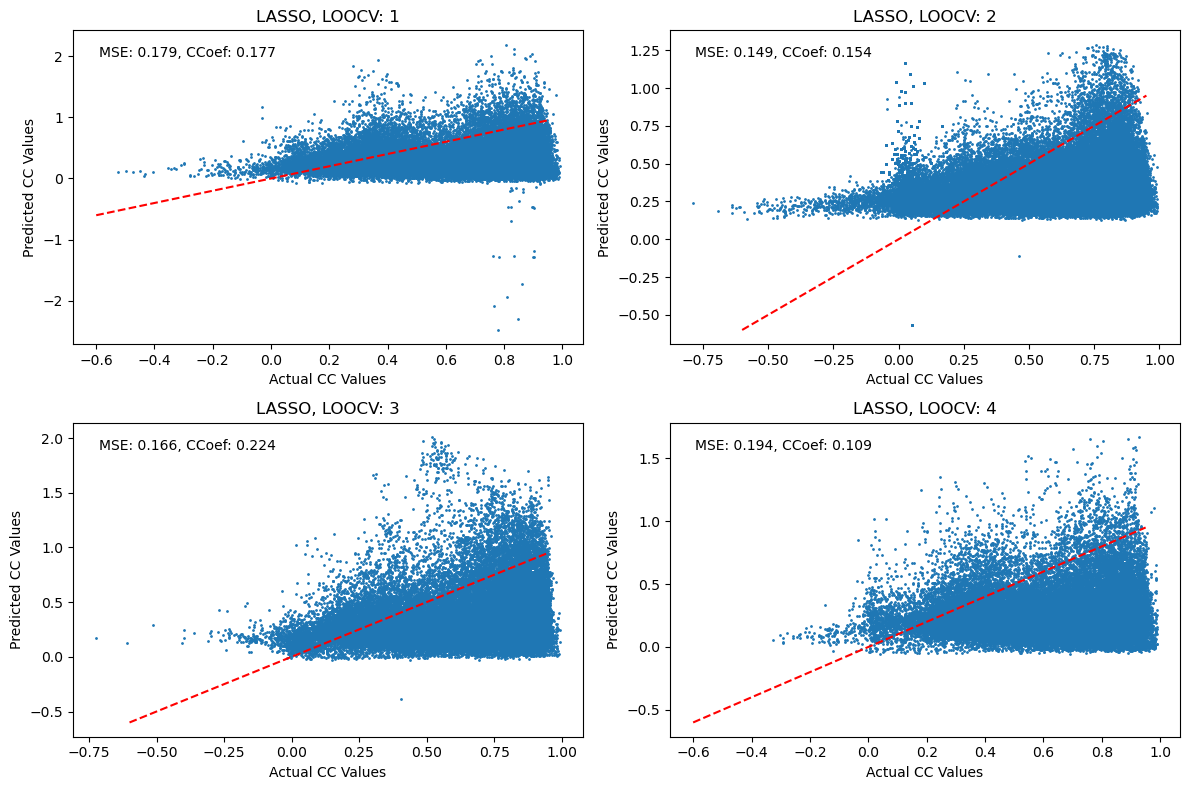

In [40]:
from sklearn.pipeline import Pipeline
target_density = 10
plt.clf()
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 8))
axs = axs.flatten()
for fov in fovs:
    test_fov = fov - 1
    train_fovs = np.delete(fovs, test_fov)
    train_fovs = train_fovs - 1
    X_test = X[test_fov]
    y_test = y[test_fov]
    X_train = np.zeros((0, X[0].shape[1]))
    y_train = np.zeros(0)
    for it_fov in train_fovs:
        X_train = np.append(X_train, X[it_fov], axis = 0)
        y_train = np.append(y_train, y[it_fov], axis = 0)
    ############## Trim Training Data ############## 
    trimmed_cc_train = trim_cc_vals(y_train, n_bins, target_density)
    original_indices_train = []
    y_train_trim = []
    
    for i in range(trimmed_cc_train['original_index'].shape[0]):
        original_indices_train.append(trimmed_cc_train['original_index'].iloc[i])
        y_train_trim.append(trimmed_cc_train['CC'].iloc[i])
    
    original_indices_train = np.array(original_indices_train)
    y_train_trim = np.array(y_train_trim)
    X_train_trim = X_train[original_indices_train, :]
    """
    pca.fit(X_train_trim) 
    Xpca_train_trim = pca.transform(X_train_trim)
    pca.fit(X_test) 
    Xpca_test = pca.transform(X_test)
    """
    inf_indc = np.array([0, 1, 6, 9])
    Xpca_train_trim = X_train_trim[:, inf_indc]
    Xpca_test = X_test[:, inf_indc]

    # Least Absolute Shrinkage and Selection Operator (LASSO)
    pipe = Pipeline([
                    ('scaler', StandardScaler()), 
                    ('lassocv', LassoCV(cv=100, max_iter=10000, tol=1e-4, selection='random'))
                    ])
    pipe.fit(Xpca_train_trim, y_train_trim)
    y_pred_lasso = pipe.predict(Xpca_test)
    mse_test = mean_squared_error(y_test, y_pred_lasso)
    correlation_matrix = np.corrcoef(y_test, y_pred_lasso)
    ################### Which features are considered "important" by LASSO ###################
    coefficients = pipe.named_steps['lassocv'].coef_
    # Identify non-zero coefficients (features to keep)
    non_zero_indices = np.where(coefficients != 0)[0]
    print(f"Indices of Non-Zero Features Selected by LassoCV: {non_zero_indices}")
    # Predict on the test set: Linear Regression
    #model_linRegFOV.fit(Xpca_train_trim, y_train_trim) # Fitting Linear Regression     
    #y_pred_linRegLOFO_trim = model_linRegFOV.predict(Xpca_test_trim)
    #mse_test = mean_squared_error(y_test_trim, y_pred_linRegLOFO_trim)
    #correlation_matrix = np.corrcoef(y_test_trim, y_pred_linRegLOFO_trim)
    corr_coeff = correlation_matrix[0, 1]
    axs[fov-1].scatter(y_test, y_pred_lasso, s = 1)
    #axs[fov-1].scatter(y_test_trim, y_pred_linRegLOFO_trim, s = 1)
    axs[fov-1].plot([-0.6, 0.95], [-0.6, 0.95], 'r--') # Best fit line 
    axs[fov-1].set_xlabel('Actual CC Values')
    axs[fov-1].set_ylabel('Predicted CC Values')
    axs[fov-1].set_title(f'LASSO, LOOCV: {fov}')
    axs[fov-1].text(0.05, 0.95, f'MSE: {mse_test:.3f}, CCoef: {corr_coeff:.3f}', 
                    transform=axs[fov-1].transAxes, 
                    verticalalignment='top',
                    horizontalalignment='left')
plt.tight_layout()
plt.show()
#plt.savefig('linRegTest4FOVs.png', dpi = 400, bbox_inches='tight')
#plt.savefig('lassoTest4FOVs.png', dpi = 400, bbox_inches='tight')

Indices of Non-Zero Features Selected by LassoCV: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
Indices of Non-Zero Features Selected by LassoCV: [ 0  1  3  4  5  6  8  9 10 11 12 13]
Indices of Non-Zero Features Selected by LassoCV: [ 0  1  2  3  4  5  6  7  8  9 10 11 13 14]
Indices of Non-Zero Features Selected by LassoCV: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 16 18]


<Figure size 640x480 with 0 Axes>

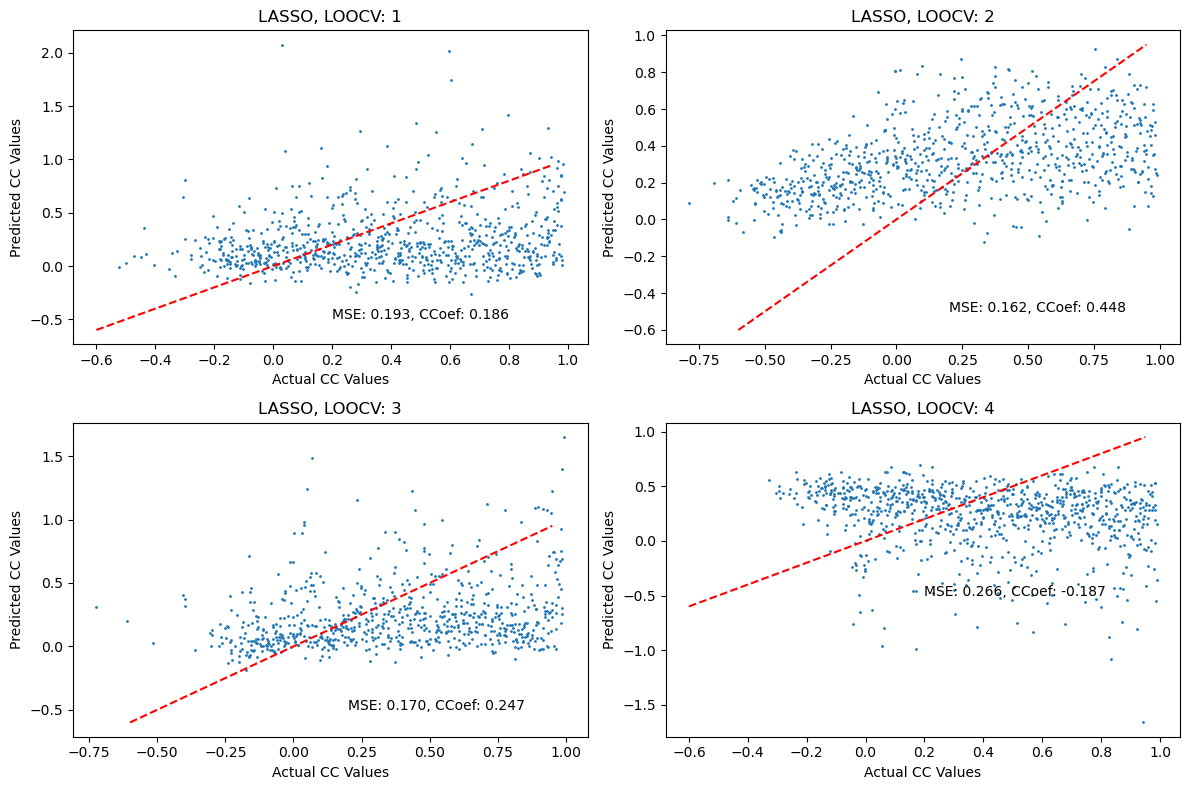

In [29]:
target_density = 10
plt.clf()
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 8))
axs = axs.flatten()
for fov in fovs:
    test_fov = fov - 1
    train_fovs = np.delete(fovs, test_fov)
    train_fovs = train_fovs - 1
    X_test = X[test_fov]
    y_test = y[test_fov]
    X_train = np.zeros((0, X[0].shape[1]))
    y_train = np.zeros(0)
    for it_fov in train_fovs:
        X_train = np.append(X_train, X[it_fov], axis = 0)
        y_train = np.append(y_train, y[it_fov], axis = 0)
    ############## Trim Training Data ############## 
    trimmed_cc_train = trim_cc_vals(y_train, n_bins, target_density)
    original_indices_train = []
    y_train_trim = []
    
    for i in range(trimmed_cc_train['original_index'].shape[0]):
        original_indices_train.append(trimmed_cc_train['original_index'].iloc[i])
        y_train_trim.append(trimmed_cc_train['CC'].iloc[i])
    
    original_indices_train = np.array(original_indices_train)
    y_train_trim = np.array(y_train_trim)
    X_train_trim = X_train[original_indices_train, :]
    
    ############## Trim Test Data ##############
    trimmed_cc_test = trim_cc_vals(y_test, n_bins, target_density)
    original_indices_test = []
    y_test_trim = []
    
    for i in range(trimmed_cc_test['original_index'].shape[0]):
        original_indices_test.append(trimmed_cc_test['original_index'].iloc[i])
        y_test_trim.append(trimmed_cc_test['CC'].iloc[i])
    
    original_indices_test = np.array(original_indices_test)
    y_test_trim = np.array(y_test_trim)
    X_test_trim = X_test[original_indices_test, :]
    """
    plt.figure(figsize = (8, 4))
    plt.hist(trimmed_cc_test['CC'], bins=n_bins, alpha=0.7, color='blue', edgecolor='black')
    plt.xlabel('CC Values')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of Trimmed CC Values of Test Set: FOV {fov}')
    plt.show()
    """
    pca.fit(X_train_trim) 
    Xpca_train_trim = pca.transform(X_train_trim)
    pca.fit(X_test_trim) 
    Xpca_test_trim = pca.transform(X_test_trim)
    # Least Absolute Shrinkage and Selection Operator (LASSO)
    model_lasso = LassoCV(alphas=None, cv=25, max_iter=10000, n_jobs=-1) 
    model_lasso.fit(Xpca_train_trim, y_train_trim)
    y_pred_lasso_trim = model_lasso.predict(Xpca_test_trim)
    mse_test = mean_squared_error(y_test_trim, y_pred_lasso_trim)
    correlation_matrix = np.corrcoef(y_test_trim, y_pred_lasso_trim)
    ################### Which features are considered "important" by LASSO ###################
    coefficients = model_lasso.coef_
    # Identify non-zero coefficients (features to keep)
    non_zero_indices = np.where(coefficients != 0)[0]
    print(f"Indices of Non-Zero Features Selected by LassoCV: {non_zero_indices}")
    #y_pred_lasso_train_trim = model_lasso.predict(Xpca_train_trim)
    #mse_train = mean_squared_error(y_train_trim, y_pred_lasso_train_trim)
    #correlation_matrix = np.corrcoef(y_train_trim, y_pred_lasso_train_trim)
    # Predict on the test set: Linear Regression
    #model_linRegFOV.fit(Xpca_train_trim, y_train_trim) # Fitting Linear Regression     
    #y_pred_linRegLOFO_trim = model_linRegFOV.predict(Xpca_test_trim)
    #mse_test = mean_squared_error(y_test_trim, y_pred_linRegLOFO_trim)
    #correlation_matrix = np.corrcoef(y_test_trim, y_pred_linRegLOFO_trim)
    # Predict on the training set: Linear Regression
    #y_pred_linRegLOFO_train_trim = model_linRegFOV.predict(Xpca_train_trim)
    #mse_train = mean_squared_error(y_train_trim, y_pred_linRegLOFO_train_trim)
    #correlation_matrix = np.corrcoef(y_train_trim, y_pred_linRegLOFO_train_trim)
    corr_coeff = correlation_matrix[0, 1]
    axs[fov-1].scatter(y_test_trim, y_pred_lasso_trim, s = 1)
    #axs[fov-1].scatter(y_train_trim, y_pred_lasso_train_trim, s = 1)
    #axs[fov-1].scatter(y_test_trim, y_pred_linRegLOFO_trim, s = 1)
    #axs[fov-1].scatter(y_train_trim, y_pred_linRegLOFO_train_trim, s = 1)
    axs[fov-1].plot([-0.6, 0.95], [-0.6, 0.95], 'r--') # Best fit line 
    axs[fov-1].set_xlabel('Actual CC Values')
    axs[fov-1].set_ylabel('Predicted CC Values')
    #axs[fov-1].set_xlabel('Actual CC Values: Training')
    #axs[fov-1].set_ylabel('Predicted CC Values: Training')
    #axs[fov-1].set_title(f'Linear Regression, LOOCV: {fov}')
    axs[fov-1].set_title(f'LASSO, LOOCV: {fov}')
    #axs[fov-1].text(0.2, -0.5, f'MSE: {mse_train:.3f}, CCoef: {corr_coeff:.3f}')
    axs[fov-1].text(0.2, -0.5, f'MSE: {mse_test:.3f}, CCoef: {corr_coeff:.3f}')
plt.tight_layout()
plt.show()
#plt.savefig('linRegTest4FOVs.png', dpi = 400, bbox_inches='tight')
#plt.savefig('linRegTrain4FOVs.png', dpi = 400, bbox_inches='tight')
#plt.savefig('lassoTest4FOVs.png', dpi = 400, bbox_inches='tight')
#plt.savefig('lassoTrain4FOVs.png', dpi = 400, bbox_inches='tight')

In [38]:
scaler = StandardScaler() # Scale features
X_train_scaled = scaler.fit_transform(Xpca_train)
X_test_scaled = scaler.transform(Xpca_test)

In [39]:
# Define classes based on CC Trajectories Analysis 
class_cutoff = 0.70
y_train_class = np.where(y_train > class_cutoff, 1, 0)  # Class 1: G1/S, Class 0: G2/M
y_test_class = np.where(y_test > class_cutoff, 1, 0)    # Same classification for test data

In [57]:
# Define the classification model
model_class = Sequential([Input(shape = (X_train_scaled.shape[1], )),
                          Dense(128, kernel_regularizer = l2(0.01)),
                          LeakyReLU(),
                          Dropout(0.5),
                          Dense(64, kernel_regularizer = l2(0.01)),
                          LeakyReLU(),
                          Dropout(0.5),
                          Dense(32, kernel_regularizer = l2(0.01)),
                          LeakyReLU(),
                          Dense(1, activation = 'sigmoid')  # Binary classification
                        ])
# The rectified linear unit (ReLU) introduces the property of nonlinearity to a DL model and solves the vanishing gradients issue
model_class.compile(optimizer = Adam(learning_rate = 0.0001),
                    loss = 'binary_crossentropy',
                    metrics = ['accuracy']) # Compile the model

# Early stopping to stop training when validation loss increases
early_stopping = EarlyStopping(monitor = 'val_loss',
                               patience = 5, 
                               restore_best_weights = True)

In [60]:
# Train the classification model
history_class = model_class.fit(X_train_scaled,
                                y_train_class, 
                                validation_split = 0.2,
                                epochs = 20, 
                                batch_size = 10,
                                callbacks=[early_stopping]) 

Epoch 1/20
12551/12551 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step - accuracy: 0.5907 - loss: 0.6777 - val_accuracy: 0.6024 - val_loss: 0.6729
Epoch 2/20
12551/12551 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step - accuracy: 0.5890 - loss: 0.6780 - val_accuracy: 0.5960 - val_loss: 0.6740
Epoch 3/20
12551/12551 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step - accuracy: 0.5901 - loss: 0.6766 - val_accuracy: 0.6016 - val_loss: 0.6716
Epoch 4/20
12551/12551 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step - accuracy: 0.5910 - loss: 0.6761 - val_accuracy: 0.5986 - val_loss: 0.6716
Epoch 5/20
12551/12551 ━━━━━━━━━━━━━━━━━━━━ 21s 1ms/step - accuracy: 0.5882 - loss: 0.6763 - val_accuracy: 0.5971 - val_loss: 0.6720
Epoch 6/20
12551/12551 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step - accuracy: 0.5904 - loss: 0.6765 - val_accuracy: 0.6082 - val_loss: 0.6715
Epoch 7/20
12551/12551 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step - accuracy: 0.5901 - loss: 0.6757 - val_accuracy: 0.5992 - val_loss: 0.6723
Epoch 8/20
12551/12551 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step - accuracy: 

<Figure size 640x480 with 0 Axes>

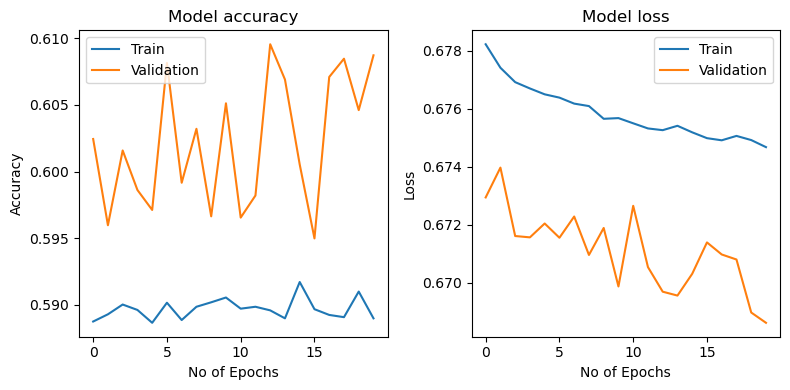

In [61]:
plt.clf()
plt.figure(figsize = (8, 4))
plt.subplot(1, 2, 1)
plt.plot(history_class.history['accuracy'])
plt.plot(history_class.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('No of Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

plt.subplot(1, 2, 2)
plt.plot(history_class.history['loss'])
plt.plot(history_class.history['val_loss'])
plt.title('Model loss')
plt.xlabel('No of Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.tight_layout()
plt.show()

In [62]:
# Predict Class Labels for the Test Set
y_pred_class = (model_class.predict(X_test_scaled) > class_cutoff).astype(int).flatten()

1346/1346 ━━━━━━━━━━━━━━━━━━━━ 1s 887us/step


In [63]:
# Split the training data into two sets based on actual classes
X_train_class0 = X_train_scaled[y_train_class == 0]
y_train_reg_class0 = y_train[y_train_class == 0]

X_train_class1 = X_train_scaled[y_train_class == 1]
y_train_reg_class1 = y_train[y_train_class == 1]

# Split the test data similarly but based on the predicted classes
X_test_class0 = X_test_scaled[y_pred_class == 0]
y_test_reg_class0 = y_test[y_pred_class == 0]

X_test_class1 = X_test_scaled[y_pred_class == 1]
y_test_reg_class1 = y_test[y_pred_class == 1]

In [73]:
# Define regression models for each class
model_reg_class0 = Sequential([Input(shape = (X_train_scaled.shape[1],)),
                               Dense(128, kernel_regularizer = l2(0.01)),
                               LeakyReLU(),
                               Dropout(0.3),
                               Dense(64, kernel_regularizer = l2(0.01)),
                               LeakyReLU(),
                               Dropout(0.3),
                               Dense(32, kernel_regularizer = l2(0.01)),
                               LeakyReLU(),
                               Dropout(0.3),
                               Dense(1)  # Regression output
                            ])

In [74]:
model_reg_class1 = Sequential([Input(shape = (X_train_scaled.shape[1],)),
                               Dense(128, kernel_regularizer = l2(0.01)),
                               LeakyReLU(),
                               Dropout(0.3),
                               Dense(64, kernel_regularizer = l2(0.01)),
                               LeakyReLU(),
                               Dropout(0.3),
                               Dense(32, kernel_regularizer = l2(0.01)),
                               LeakyReLU(),
                               Dropout(0.3),
                               Dense(1)  # Regression output
                            ])

In [75]:
# Compile the models for both classes 
model_reg_class0.compile(optimizer = Adam(learning_rate = 0.001),
                         loss = 'mean_squared_error',
                         metrics = ['accuracy'])

In [76]:
model_reg_class1.compile(optimizer = Adam(learning_rate = 0.001),
                         loss = 'mean_squared_error',
                         metrics = ['accuracy'])

In [77]:
# Train the models for both classes 
history_reg_class0 = model_reg_class0.fit(X_train_class0,
                                          y_train_reg_class0, 
                                          validation_split = 0.2, 
                                          epochs = 10,
                                          batch_size = 10)

Epoch 1/10
6346/6346 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - accuracy: 0.0000e+00 - loss: 0.4172 - val_accuracy: 0.0000e+00 - val_loss: 0.0356
Epoch 2/10
6346/6346 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0454 - val_accuracy: 0.0000e+00 - val_loss: 0.0359
Epoch 3/10
6346/6346 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0451 - val_accuracy: 0.0000e+00 - val_loss: 0.0362
Epoch 4/10
6346/6346 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0448 - val_accuracy: 0.0000e+00 - val_loss: 0.0354
Epoch 5/10
6346/6346 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0451 - val_accuracy: 0.0000e+00 - val_loss: 0.0358
Epoch 6/10
6346/6346 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0457 - val_accuracy: 0.0000e+00 - val_loss: 0.0359
Epoch 7/10
6346/6346 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0452 - val_accuracy: 0.0000e+00 - val_loss: 0.0357
Epoch 8/10
6346/6346 ━━━━━━━━━━━━

<Figure size 640x480 with 0 Axes>

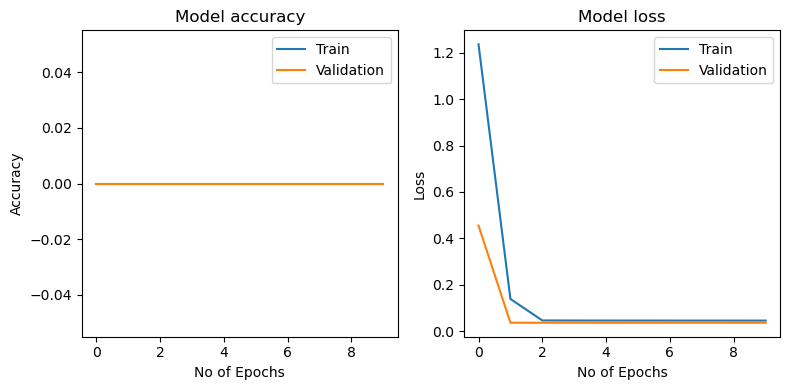

In [69]:
plt.clf()
plt.figure(figsize = (8, 4))
plt.subplot(1, 2, 1)
plt.plot(history_reg_class0.history['accuracy'])
plt.plot(history_reg_class0.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('No of Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

plt.subplot(1, 2, 2)
plt.plot(history_reg_class0.history['loss'])
plt.plot(history_reg_class0.history['val_loss'])
plt.title('Model loss')
plt.xlabel('No of Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.tight_layout()
plt.show()

In [ ]:
history_reg_class1 = model_reg_class1.fit(X_train_class1,
                                          y_train_reg_class1,
                                          validation_split = 0.2, 
                                          epochs = 50, 
                                          batch_size = 10)

In [ ]:
plt.clf()
plt.figure(figsize = (8, 4))
plt.subplot(1, 2, 1)
plt.plot(history_reg_class1.history['accuracy'])
plt.plot(history_reg_class1.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('No of Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

plt.subplot(1, 2, 2)
plt.plot(history_reg_class1.history['loss'])
plt.plot(history_reg_class1.history['val_loss'])
plt.title('Model loss')
plt.xlabel('No of Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.tight_layout()
plt.show()

In [ ]:
# Predict on the test sets
y_pred_reg_class0 = model_reg_class0.predict(X_test_class0)
mse_class0 = mean_squared_error(y_test_reg_class0, y_pred_reg_class0)
print(f"Mean Squared Error: {mse_class0}")

In [ ]:
plt.clf()
plt.figure(figsize = (9, 6))
plt.scatter(y_test_reg_class0, y_pred_reg_class0, s = 1)
plt.plot([-0.6, 0.1], [-0.6, 0.1], 'r--') # Best fit line 
plt.xlabel('Actual CC Values')
plt.ylabel('Predicted CC Values')
plt.title('Actual vs. Predicted CC Values: DNN')
plt.tight_layout()
plt.show()

In [ ]:
y_pred_reg_class1 = model_reg_class1.predict(X_test_class1)
mse_class1 = mean_squared_error(y_test_reg_class1, y_pred_reg_class1)
print(f"Mean Squared Error: {mse_class1}")

In [ ]:
plt.clf()
plt.figure(figsize = (9, 6))
plt.scatter(y_test_reg_class1, y_pred_reg_class1, s = 1)
plt.plot([0.65, 1.0], [0.65, 1.0], 'r--') # Best fit line 
plt.xlabel('Actual CC Values')
plt.ylabel('Predicted CC Values')
plt.title('Actual vs. Predicted CC Values: DNN')
plt.tight_layout()
plt.show()

In [ ]:
n_bins = 100
plt.figure(figsize = (9, 6))
plt.hist(y_train, bins = n_bins, alpha = 0.5, color = 'g', label = 'Trainng Set')
plt.hist(y_test, bins = n_bins, alpha = 0.5, color='r', label = 'Test Set')

plt.xlabel('CC Values')
plt.ylabel('Frequency')
plt.title('Histogram of CC Values')
plt.legend()
plt.grid(True)
plt.show()

In [35]:
num_features = 50
pca = PCA(n_components = num_features)

In [ ]:
pca.fit(X_train) 
Xpca_train = pca.transform(X_train)
pca.fit(X_test) 
Xpca_test = pca.transform(X_test)

In [ ]:
model_linReg1 = LinearRegression(n_jobs=-1)
model_linReg1.fit(Xpca_train, y_train)

# Predict on the test sets: Linear Regression
y_pred_linReg_wot = model_linReg1.predict(Xpca_test)
mse = mean_squared_error(y_test, y_pred_linReg_wot)
print(f"Mean Squared Error: {mse}")

In [ ]:
plt.clf()
plt.figure(figsize = (9, 6))
plt.scatter(y_test, y_pred_linReg_wot, s = 1)
plt.plot([-0.6, 0.95], [-0.6, 0.95], 'r--') # Best fit line 
plt.xlabel('Actual CC Values')
plt.ylabel('Predicted CC Values')
plt.title('Actual vs. Predicted CC Values: Linear Regression')
plt.show()

In [ ]:
# Predict on the training set: Linear Regression
y_pred_linReg_train_wot = model_linReg1.predict(Xpca_train)

In [ ]:
plt.figure(figsize = (7,5))
plt.scatter(y_train, y_pred_linReg_train_wot, s = 1)
plt.show()

In [ ]:
num_bins = 100 # Number of bins
target_density = 10 # Define target bin density

In [ ]:
trimmed_cc_train = trim_cc_vals(y_train, num_bins, target_density)

In [ ]:
plt.clf()
plt.figure(figsize = (5, 4))
plt.hist(trimmed_cc_train['CC'], bins=num_bins, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('CC Values')
plt.ylabel('Frequency')
plt.title('Histogram of Trimmed CC Values: Training Set')
plt.show()

In [ ]:
original_indices_train = []
y_train_trim = []

for i in range(trimmed_cc_train['original_index'].shape[0]):
    original_indices_train.append(trimmed_cc_train['original_index'].iloc[i])
    y_train_trim.append(trimmed_cc_train['CC'].iloc[i])

original_indices_train = np.array(original_indices_train)
y_train_trim = np.array(y_train_trim)
X_train_trim = X_train[original_indices_train, :]

In [ ]:
trimmed_cc_test = trim_cc_vals(y_test, num_bins, target_density)

In [ ]:
plt.clf()
plt.figure(figsize = (5, 4))
plt.hist(trimmed_cc_test['CC'], bins=num_bins, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('CC Values')
plt.ylabel('Frequency')
plt.title('Histogram of Trimmed CC Values: Test Set')
plt.show()

In [ ]:
original_indices_test = []
y_test_trim = []

for i in range(trimmed_cc_test['original_index'].shape[0]):
    original_indices_test.append(trimmed_cc_test['original_index'].iloc[i])
    y_test_trim.append(trimmed_cc_test['CC'].iloc[i])

original_indices_test = np.array(original_indices_test)
y_test_trim = np.array(y_test_trim)
X_test_trim = X_train[original_indices_test, :]

In [ ]:
num_features = 50
pca = PCA(n_components = num_features)

In [ ]:
pca.fit(X_train_trim) 
Xpca_train_trim = pca.transform(X_train_trim)
pca.fit(X_test_trim) 
Xpca_test_trim = pca.transform(X_test_trim)

In [ ]:
model_linReg = LinearRegression(n_jobs=-1)
model_linReg.fit(Xpca_train_trim, y_train_trim)

# Predict on the test sets: Linear Regression
y_pred_linReg = model_linReg.predict(Xpca_test_trim)
mse = mean_squared_error(y_test_trim, y_pred_linReg)
print(f"Mean Squared Error: {mse}")

plt.clf()
plt.figure(figsize = (9, 6))
plt.scatter(y_test_trim, y_pred_linReg, s = 1)
plt.plot([-0.6, 0.95], [-0.6, 0.95], 'r--') # Best fit line 
plt.xlabel('Actual CC Values')
plt.ylabel('Predicted CC Values')
plt.title('Actual vs. Predicted CC Values: Linear Regression')
plt.show()

In [ ]:
# Predict on the training set: Linear Regression
y_pred_linReg_train = model_linReg.predict(Xpca_train_trim)

In [ ]:
plt.figure(figsize = (7,5))
plt.scatter(y_train_trim, y_pred_linReg_train, s = 1)
plt.show()

In [ ]:
correlation_matrix = np.corrcoef(y_train_trim, y_pred_linReg_train)
correlation_coefficient = correlation_matrix[0, 1]
print("Correlation Coefficient:", correlation_coefficient)

In [ ]:
n_comp_pca = 20
pca_tmp = PCA(n_components = n_comp_pca)

In [ ]:
pca_tmp.fit(X_train) 
Xpca_train_plt = pca_tmp.transform(X_train)

In [ ]:
pca_tmp.fit(X_test) 
Xpca_test_plt = pca_tmp.transform(X_test)

In [ ]:
for i in range(n_comp_pca):
    correlation_matrix = np.corrcoef(y_train, Xpca_train_plt[:, i])
    correlation_coefficient = correlation_matrix[0, 1]
    print("Correlation Coefficient:", correlation_coefficient)

In [ ]:
for i in range(n_comp_pca):
    corr_coefficient, p_value = scipy.stats.pearsonr(y_train, Xpca_train_plt[:, i])
    plt.clf()
    plt.figure(figsize=(8, 6))
    plt.scatter(y_train, Xpca_train_plt[:, i], color='blue', label=f'Correlation: {corr_coefficient:.2f}')

    plt.title('Correlations')
    plt.xlabel('CC Values')
    plt.ylabel('Featutes info')
    sns.regplot(y_train, Xpca_train_plt[:, i], scatter=False, color="red", ci=None)
    plt.legend()
    plt.show()

In [ ]:
for i in range(n_comp_pca): 
   plt.clf()
   plt.figure(figsize = (7, 5))
   plt.scatter(y_train, Xpca_train_plt[:, i], s=1)
   plt.xlabel('CC Values')
   plt.ylabel(f'PC {i+1}')
   plt.pause(0.5)

In [ ]:
plt.clf()
plt.figure(figsize = (8, 6))
scatter_plot = plt.scatter(Xpca_train_plt[:, 0], Xpca_train_plt[:, 1], c=y_train, s=1, cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')
colorbar = plt.colorbar(scatter_plot)
colorbar.set_label('Training set CC values')
plt.show()

In [ ]:
plt.clf()
plt.figure(figsize = (8, 6))
scatter_plot = plt.scatter(Xpca_test_plt[:, 0], Xpca_test_plt[:, 1], c=y_test, s=1, cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')
colorbar = plt.colorbar(scatter_plot)
colorbar.set_label('Test set CC values')
plt.show()

Separate Data Into Two Uniform Classes (Sets)

In [ ]:
data = y_train; threshold_train = 0.7
cond_class1 = data > threshold_train
indices_class1 = np.where(cond_class1)[0]
cond_class2 = data <= threshold_train
indices_class2 = np.where(cond_class2)[0]

print(f"Training Set Sizes of Class 1: {indices_class1.size} and Class2: {indices_class2.size}")

y_train_class1 = y_train[indices_class1]
y_train_class2 = y_train[indices_class2]
X_train_class1 = X_train[indices_class1, :]
X_train_class2 = X_train[indices_class2, :]

In [ ]:
data = y_test; threshold_test = 0.7
cond_class1 = data > threshold_test
indices_class1 = np.where(cond_class1)[0]
cond_class2 = data <= threshold_test
indices_class2 = np.where(cond_class2)[0]

print(f"Test Set Sizes of Class 1: {indices_class1.size} and Class2: {indices_class2.size}")

y_test_class1 = y_test[indices_class1]
y_test_class2 = y_test[indices_class2]
X_test_class1 = X_test[indices_class1, :]
X_test_class2 = X_test[indices_class2, :]

In [ ]:
num_features = 15
pca = PCA(n_components = num_features)
#pca = PCA(n_components = 0.99)

In [ ]:
pca.fit(X_train_class1) 
Xpca_train_class1 = pca.transform(X_train_class1)
pca.fit(X_train_class2) 
Xpca_train_class2 = pca.transform(X_train_class2)

In [ ]:
pca.fit(X_test_class1) 
Xpca_test_class1 = pca.transform(X_test_class1)
pca.fit(X_test_class2) 
Xpca_test_class2 = pca.transform(X_test_class2)

In [ ]:
model_linReg_class1 = LinearRegression(n_jobs=-1)
model_linReg_class1.fit(Xpca_train_class1, y_train_class1)

# Predict on the test sets: Linear Regression
y_pred_linReg_class1 = model_linReg_class1.predict(Xpca_test_class1)
mse = mean_squared_error(y_test_class1, y_pred_linReg_class1)
print(f"Mean Squared Error: {mse}")

plt.clf()
plt.figure(figsize = (9, 6))
plt.scatter(y_test_class1, y_pred_linReg_class1, s = 1)
plt.plot([0.7, 0.95], [0.7, 0.95], 'r--') # Best fit line 
plt.xlabel('Actual CC Values')
plt.ylabel('Predicted CC Values')
plt.title('Actual vs. Predicted CC Values: Linear Regression')
plt.show()

In [ ]:
# Define linear regression models for each class
model_linReg_class2 = LinearRegression(n_jobs=-1)
# Train the models: Linear Regression
model_linReg_class2.fit(Xpca_train_class2, y_train_class2)

# Predict on the test sets: Linear Regression
y_pred_linReg_class2 = model_linReg_class2.predict(Xpca_test_class2)
mse = mean_squared_error(y_test_class2, y_pred_linReg_class2)
print(f"Mean Squared Error: {mse}")

plt.clf()
plt.figure(figsize = (9, 6))
plt.scatter(y_test_class2, y_pred_linReg_class2, s = 1)
plt.plot([-0.45, 0.7], [-0.45, 0.7], 'r--') # Best fit line 
plt.xlabel('Actual CC Values')
plt.ylabel('Predicted CC Values')
plt.title('Actual vs. Predicted CC Values: Linear Regression')
plt.show()

Random Forest Regression Model Using Recursive Feature Elimination with Cross Validations 

In [ ]:
n_folds_cv = 10
cv_kFold = KFold(n_splits = n_folds_cv, # n_splits fold cross-validations 
                 shuffle = True,
                 random_state = 42) # Simple K-fold Cross Validations

In [ ]:
model_RF = RandomForestRegressor(n_estimators = 40, # Number of Trees 
                                 random_state = 42) 

In [ ]:
rfecv_RF = RFECV(estimator = model_RF,
                 step = 1, 
                 cv = cv_kFold, 
                 scoring = 'neg_mean_squared_error',  # Using negative MSE as the scoring method
                 min_features_to_select = 1,
                 verbose = 1,
                 n_jobs = -1)

In [ ]:
rfecv_RF.fit(Xpca_train, y_train_pos) # Recursive Feature Elimination Cross-Validation

In [ ]:
y_pred_RF = rfecv_RF.predict(Xpca_test) # Predicting the test set results

In [ ]:
plt.figure(figsize = (8, 7))
plt.scatter(y_test_pos, y_pred_RF, s = 1)
plt.xlabel('Actual CC values')
plt.ylabel('Predicted CC values')
plt.title('Predicted vs. Actual CC values: Random Forest Regression')
plt.grid(True)

# Calculate the range to include both actual and predicted values
min_val = min(y_test_pos.min(), y_pred_RF.min())
max_val = max(y_test_pos.max(), y_pred_RF.max())
line_coords = np.linspace(min_val, max_val, 100)

plt.plot(line_coords, line_coords, color='red', linestyle='--')  # Perfect prediction
plt.tight_layout()
#plt.savefig(figid+'CCvalsPred_testFOV1_RF.png', dpi=400)
plt.show()

In [ ]:
min_features_to_select = 1
n_scores = len(rfecv_RF.cv_results_["mean_test_score"])
plt.figure(figsize = (5, 4))
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(range(min_features_to_select, n_scores + min_features_to_select), rfecv_RF.cv_results_["mean_test_score"], 
             yerr=rfecv_RF.cv_results_["std_test_score"])
plt.title("RFE with correlated features")
plt.tight_layout()
plt.savefig(figid+'test_accuracyFOV1_RF.png', dpi=400)
#plt.show()

In [ ]:
print(f"Number of Predictive Features: {rfecv_RF.n_features_}")
selected_features = np.where(rfecv_RF.support_ == True)[0] # Identifying the selected features
print(f"Most Predictive Feature Indices:{selected_features}")

In [ ]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(Xpca_train)
X_test_scaled = scaler.transform(Xpca_test)

In [ ]:
# Define classes based on CC Trajectories Analysis 
class_cutoff = 0.30
y_train_class = np.where(y_train > class_cutoff, 1, 0)  # Class 1: G1/S, Class 0: G2/M
y_test_class = np.where(y_test > class_cutoff, 1, 0)    # Same classification for test data

In [ ]:
# Define the classification model
model_class = Sequential([Input(shape = (X_train_scaled.shape[1], )),
                          #Dense(1024),
                          #LeakyReLU(),
                          #Dense(512, kernel_regularizer = l2(0.01)),
                          #LeakyReLU(),
                          #Dense(256),
                          #LeakyReLU(),
                          Dense(128, kernel_regularizer = l2(0.01)),
                          LeakyReLU(),
                          Dropout(0.5),
                          Dense(64, kernel_regularizer = l2(0.01)),
                          LeakyReLU(),
                          Dropout(0.5),
                          Dense(32, kernel_regularizer = l2(0.01)),
                          LeakyReLU(),
                          Dense(1, activation = 'sigmoid')  # Binary classification
                        ])
"""
Dense(1024, activation = 'relu'),
Dense(512, activation = 'relu', kernel_regularizer = l2(0.01)),
Dense(256, activation = 'relu'),
Dense(128, activation = 'relu', kernel_regularizer = l2(0.01)),
Dense(64, activation = 'relu'),
Dense(32, activation = 'relu'),
"""
# The rectified linear unit (ReLU) introduces the property of nonlinearity to a DL model and solves the vanishing gradients issue
model_class.compile(optimizer = Adam(learning_rate = 0.0001),
                    loss = 'binary_crossentropy',
                    metrics = ['accuracy']) # Compile the model

# Early stopping to stop training when validation loss increases
early_stopping = EarlyStopping(monitor = 'val_loss',
                               patience = 20, 
                               restore_best_weights = True)

In [ ]:
# Train the model
history_class = model_class.fit(X_train_scaled,
                                y_train_class, 
                                validation_split = 0.2,
                                epochs = 50, 
                                batch_size = 10)
                                #callbacks=[early_stopping]) 

In [ ]:
plt.clf()
plt.figure(figsize = (8, 4))
plt.subplot(1, 2, 1)
plt.plot(history_class.history['accuracy'])
plt.plot(history_class.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('No of Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

plt.subplot(1, 2, 2)
plt.plot(history_class.history['loss'])
plt.plot(history_class.history['val_loss'])
plt.title('Model loss')
plt.xlabel('No of Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.tight_layout()
plt.show()

In [ ]:
# Predict Class Labels for the Test Set
y_pred_class = (model_class.predict(X_test_scaled) > class_cutoff).astype(int).flatten()

In [ ]:
print(f"Size of Class 0: {np.where(y_pred_class == 0)[0].size}")

In [ ]:
# Split the training data into two sets based on actual classes
X_train_class0 = X_train_scaled[y_train_class == 0]
y_train_reg_class0 = y_train[y_train_class == 0]

X_train_class1 = X_train_scaled[y_train_class == 1]
y_train_reg_class1 = y_train[y_train_class == 1]

# Split the test data similarly but based on the predicted classes
X_test_class0 = X_test_scaled[y_pred_class == 0]
y_test_reg_class0 = y_test[y_pred_class == 0]

X_test_class1 = X_test_scaled[y_pred_class == 1]
y_test_reg_class1 = y_test[y_pred_class == 1]

In [ ]:
# Define regression models for each class
model_reg_class0 = Sequential([Input(shape = (X_train_scaled.shape[1],)),
                               Dense(128, kernel_regularizer = l2(0.01)),
                               LeakyReLU(),
                               Dropout(0.3),
                               Dense(64, kernel_regularizer = l2(0.01)),
                               LeakyReLU(),
                               Dropout(0.3),
                               Dense(32, kernel_regularizer = l2(0.01)),
                               LeakyReLU(),
                               Dropout(0.3),
                               Dense(1)  # Regression output
                            ])

In [ ]:
model_reg_class1 = Sequential([Input(shape = (X_train_scaled.shape[1],)),
                               Dense(1024, kernel_regularizer = l2(0.01)),
                               LeakyReLU(),
                               Dense(512),
                               LeakyReLU(),
                               Dropout(0.5),
                               Dense(256),
                               LeakyReLU(),
                               Dense(128, kernel_regularizer = l2(0.01)),
                               LeakyReLU(),
                               Dense(64),
                               LeakyReLU(),
                               Dropout(0.5),
                               Dense(32),
                               LeakyReLU(),
                               Dense(1)  # Regression output
                            ])

In [ ]:
# Compile the models for both classes 
model_reg_class0.compile(optimizer = Adam(learning_rate = 0.0001),
                         loss = 'mean_squared_error',
                         metrics = ['accuracy'])

In [ ]:
model_reg_class1.compile(optimizer = Adam(learning_rate = 0.0001),
                         loss = 'mean_squared_error',
                         metrics = ['accuracy'])

In [ ]:
# Train the models for both classes 
history_reg_class0 = model_reg_class0.fit(X_train_scaled,
                                          y_train_neg, 
                                          validation_split = 0.2, 
                                          epochs = 50,
                                          batch_size = 10)

In [ ]:
plt.clf()
plt.figure(figsize = (8, 4))
plt.subplot(1, 2, 1)
plt.plot(history_reg_class0.history['accuracy'])
plt.plot(history_reg_class0.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('No of Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

plt.subplot(1, 2, 2)
plt.plot(history_reg_class0.history['loss'])
plt.plot(history_reg_class0.history['val_loss'])
plt.title('Model loss')
plt.xlabel('No of Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.tight_layout()
plt.show()

In [ ]:
history_reg_class1 = model_reg_class1.fit(X_train_scaled,
                                          y_train_pos,
                                          validation_split = 0.2, 
                                          epochs = 50, 
                                          batch_size = 10)

In [ ]:
plt.clf()
plt.figure(figsize = (8, 4))
plt.subplot(1, 2, 1)
plt.plot(history_reg_class1.history['accuracy'])
plt.plot(history_reg_class1.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('No of Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

plt.subplot(1, 2, 2)
plt.plot(history_reg_class1.history['loss'])
plt.plot(history_reg_class1.history['val_loss'])
plt.title('Model loss')
plt.xlabel('No of Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.tight_layout()
plt.show()

In [ ]:
# Predict on the test sets
y_pred_reg_class0 = model_reg_class0.predict(X_test_scaled)
mse = mean_squared_error(y_test_neg, y_pred_reg_class0)
print(f"Mean Squared Error: {mse}")

In [ ]:
plt.clf()
plt.figure(figsize = (9, 6))
plt.scatter(y_test_neg, y_pred_reg_class0, s = 1)
plt.plot([-0.6, 0.1], [-0.6, 0.1], 'r--') # Best fit line 
plt.xlabel('Actual CC Values')
plt.ylabel('Predicted CC Values')
plt.title(' Actual vs. Predicted CC Values: Artificial Neural Networks ')
plt.tight_layout()
plt.show()

In [ ]:
y_pred_reg_class1 = model_reg_class1.predict(X_test_scaled)
mse = mean_squared_error(y_test_pos, y_pred_reg_class1)
print(f"Mean Squared Error: {mse}")

In [ ]:
plt.clf()
plt.figure(figsize = (9, 6))
plt.scatter(y_test_pos, y_pred_reg_class1, s = 1)
plt.plot([0.65, 1.0], [0.65, 1.0], 'r--') # Best fit line 
plt.xlabel('Actual CC Values')
plt.ylabel('Predicted CC Values')
plt.title(' Actual vs. Predicted CC Values: Artificial Neural Networks ')
plt.tight_layout()
plt.show()

Sequential Model

In [ ]:
model_NN = Sequential([Input(shape = (X_train_scaled.shape[1], )),
                       Dense(1024, activation = 'relu'),
                       Dropout(0.2),
                       Dense(512, activation = 'relu'),
                       LeakyReLU(),
                       Dense(256, activation = 'relu', kernel_regularizer = l2(0.02)), 
                       #LeakyReLU(), 
                       #Dropout(0.2),
                       Dense(128, activation = 'relu'),
                       LeakyReLU(),
                       Dropout(0.2),
                       Dense(64, activation = 'relu'),
                       #Dropout(0.2),
                       Dense(32, activation = 'relu'),
                       Dense(1)])

Functional API Model

In [ ]:
inputs_nn = Input(shape=(X_train_scaled.shape[1], ))
x_nn = Dense(512, activation = 'relu')(inputs_nn)
x_nn = Dense(256, activation = 'relu')(x_nn)
x_nn = Dense(128, activation = 'relu')(x_nn)
x_nn = Dense(64, activation = 'relu')(x_nn)
x_nn = Dense(32, activation = 'relu')(x_nn)
outputs_nn = Dense(1)(x_nn) 

model_NN = Model(inputs = inputs_nn, outputs = outputs_nn)

In [ ]:
optimizer = Adam(learning_rate = 0.0001)
#optimizer = SGD(learning_rate = 0.0001)
model_NN.compile(optimizer = optimizer, loss = 'mean_squared_error')

In [ ]:
history = model_NN.fit(X_train_scaled,
                       y_train,
                       validation_split = 0.2,
                       epochs = 200,
                       batch_size = 10) 

In [ ]:
mse_nn = model_NN.evaluate(X_test_scaled, y_test)
print(f"Mean Squared Error on Test set: {mse_nn}")

In [ ]:
y_pred_nn = model_NN.predict(X_test_scaled)

In [ ]:
plt.figure(figsize = (8, 7))
plt.scatter(y_test, y_pred_nn, s = 1)

# Calculate the range to include both actual and predicted values
min_val = min(y_test.min(), y_pred_nn.min())
max_val = max(y_test.max(), y_pred_nn.max())
line_coords = np.linspace(min_val, max_val, 100)

plt.plot(line_coords, line_coords, color = 'red', linestyle = '--')  # Perfect prediction
plt.xlabel('Actual CC values')
plt.ylabel('Predicted CC values')
plt.title('Actual vs. NN Regression Predictions of CC values')
plt.tight_layout()
#plt.savefig(figid+'CCvalsPred_testNN.png', dpi=400)
plt.show()